In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

from helpers.ann_tools import ANN, import_ANN, export_ANN
import torch
import torch.optim as optim

import hvplot.xarray
import hvplot
import cmocean
import os
from time import time

%load_ext autoreload
%autoreload 3

# Read datasets

In [2]:
def read_datasets(operator_str = 'Filtering(FGR=2)+CoarsenKochkov()', factors = [4,6,9,12]): 
    d = {}
    for factor in factors:
        for key in ['train', 'test']:
            data = xr.open_mfdataset(
                f'/scratch/pp2681/mom6/CM26_datasets/{operator_str}/factor-{factor}/{key}*.nc', chunks={'time':1})
            param = xr.open_mfdataset(
                f'/scratch/pp2681/mom6/CM26_datasets/{operator_str}/factor-{factor}/param.nc')
            d[f'{key}-{factor}'] = DatasetCM26(data, param)
            print(f'Dataset has been read: {operator_str}-{key}-{factor}')
    return d

In [3]:
%time dataset = read_datasets()

Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-train-4
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-test-4
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-train-6
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-test-6
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-train-9
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-test-9
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-train-12
Dataset has been read: Filtering(FGR=2)+CoarsenKochkov()-test-12
CPU times: user 4.46 s, sys: 2.63 s, total: 7.09 s
Wall time: 30.5 s


# Training script

In [113]:
log_dict = {}
ann_Txy = ANN([27, 20, 1])
ann_Txx_Tyy = ANN([27, 20, 2])

In [114]:
num_epochs=5
print_epochs=1

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    t_e = time()
    
    for factor in [4,6,9,12]:
        
        batch = dataset[f'train-{factor}'].split()
        SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
        SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)
        
        SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())
        SGSx = SGS_norm * SGSx
        SGSy = SGS_norm * SGSy
        
        # order of loops is such that the last iteration
        # is standard model without augmentation
        if True:
            for rotation in [90, 0]:
                for reflect_x in [True, False]:
                    for reflect_y in [True, False]:

                        optimizer.zero_grad()
                        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy,
                            rotation=rotation, reflect_x=reflect_x, reflect_y=reflect_y)

                        ANNx = prediction['ZB20u'] * SGS_norm
                        ANNy = prediction['ZB20v'] * SGS_norm
                        MSE_train = ((ANNx-SGSx)**2 + (ANNy-SGSy)**2).mean()

                        MSE_train.backward()
                        optimizer.step()
        else:
            optimizer.zero_grad()
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)

            ANNx = prediction['ZB20u'] * SGS_norm
            ANNy = prediction['ZB20v'] * SGS_norm
            MSE_train = ((ANNx-SGSx)**2 + (ANNy-SGSy)**2).mean()

            MSE_train.backward()
            optimizer.step()
        
        del batch
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = dataset[f'test-{factor}'].split()
            SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
            SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)
            SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())
            SGSx = SGS_norm * SGSx
            SGSy = SGS_norm * SGSy
            
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
            ANNx = prediction['ZB20u'] * SGS_norm
            ANNy = prediction['ZB20v'] * SGS_norm

            MSE_test = ((ANNx-SGSx)**2 + (ANNy-SGSy)**2).mean()
            del batch
        
        if (epoch+1) % print_epochs == 0:
            print(f'Factor: {factor}. '+'MSE train/test: [%.6f, %.6f]' % (float(MSE_train.data), float(MSE_test.data)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = dict(MSE_train=float(MSE_train.data),MSE_test=float(MSE_test.data))
    t = time()
    if (epoch+1) % print_epochs == 0:
        print(f'Epoch/Total [{epoch+1}/{num_epochs}]: Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()
    
#     if (epoch+1) % 50 == 0:
#         export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
#            filename=f'trained_models/ANN_CM26_Kochkov_augmented/Txy_epoch_{epoch+1}.nc')
#         export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
#            filename=f'trained_models/ANN_CM26_Kochkov_augmented/Txx_Tyy_epoch_{epoch+1}.nc')
#         with open(f'trained_models/ANN_CM26_Kochkov_augmented/log_dict_epoch_{epoch+1}', 'w') as file:
#             json.dump(log_dict, file)

Factor: 4. MSE train/test: [15.610239, 14.641606]
Factor: 6. MSE train/test: [5.917899, 5.403565]
Factor: 9. MSE train/test: [2.802359, 2.658417]
Factor: 12. MSE train/test: [2.152054, 1.989458]
Epoch/Total [1/5]: Epoch time/Remaining time in seconds: [5/20]
Factor: 4. MSE train/test: [5.893455, 4.958116]
Factor: 6. MSE train/test: [2.254996, 2.053403]
Factor: 9. MSE train/test: [1.319515, 1.203139]
Factor: 12. MSE train/test: [1.101352, 1.092962]
Epoch/Total [2/5]: Epoch time/Remaining time in seconds: [5/15]
Factor: 4. MSE train/test: [2.251339, 2.277319]
Factor: 6. MSE train/test: [1.454152, 1.465576]
Factor: 9. MSE train/test: [1.196318, 1.211707]
Factor: 12. MSE train/test: [1.112831, 1.031812]
Epoch/Total [3/5]: Epoch time/Remaining time in seconds: [5/10]
Factor: 4. MSE train/test: [2.282060, 2.074473]
Factor: 6. MSE train/test: [1.383194, 1.357830]
Factor: 9. MSE train/test: [1.126341, 1.123537]
Factor: 12. MSE train/test: [1.071412, 1.027033]
Epoch/Total [4/5]: Epoch time/Rema

# Test old ANN

In [122]:
ann_Txy = import_ANN('../trained_models/ANN_CM26_Kochkov/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('../trained_models/ANN_CM26_Kochkov/Txx_Tyy_epoch_2000.nc')

In [123]:
%time dataset = read_datasets('CoarsenKochkov()')

Dataset has been read: CoarsenKochkov()-train-4
Dataset has been read: CoarsenKochkov()-test-4
Dataset has been read: CoarsenKochkov()-train-6
Dataset has been read: CoarsenKochkov()-test-6
Dataset has been read: CoarsenKochkov()-train-9
Dataset has been read: CoarsenKochkov()-test-9
Dataset has been read: CoarsenKochkov()-train-12
Dataset has been read: CoarsenKochkov()-test-12
CPU times: user 4.29 s, sys: 2.53 s, total: 6.82 s
Wall time: 26.1 s


Correlation: 0.6564683218710512
Relative Error: 0.8594648241996765
R2 =  0.42847496271133423
R2 max =  0.43094849586486816
Optinal scaling: 1.0819711685180664
Nans [test/control]: [7403, 7403]
Correlation: 0.44948226717352957
Relative Error: 0.9269417524337769
R2 =  0.2012295126914978
R2 max =  0.20203465223312378
Optinal scaling: 1.0673809051513672
Nans [test/control]: [3224, 3224]
Correlation: 0.391034501221515
Relative Error: 0.9491578936576843
R2 =  0.14932459592819214
R2 max =  0.15289098024368286
Optinal scaling: 1.1802622079849243
Nans [test/control]: [1345, 1345]


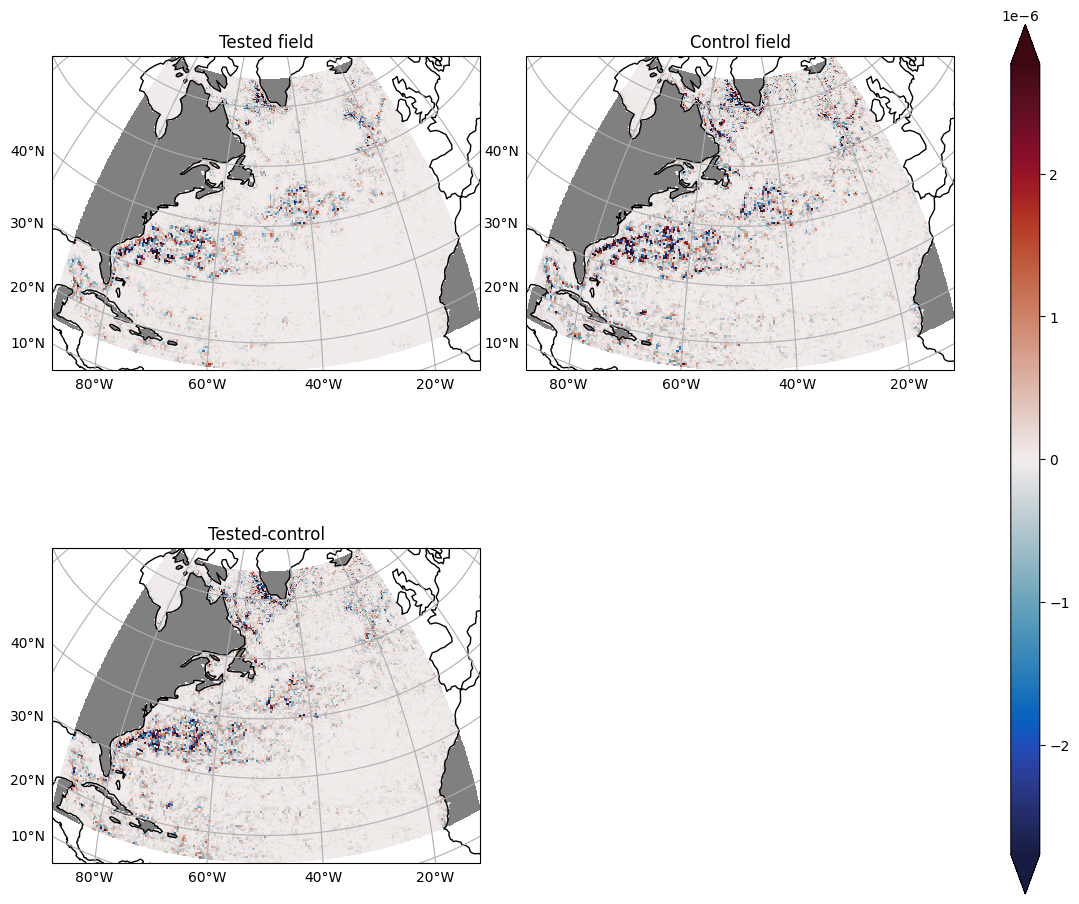

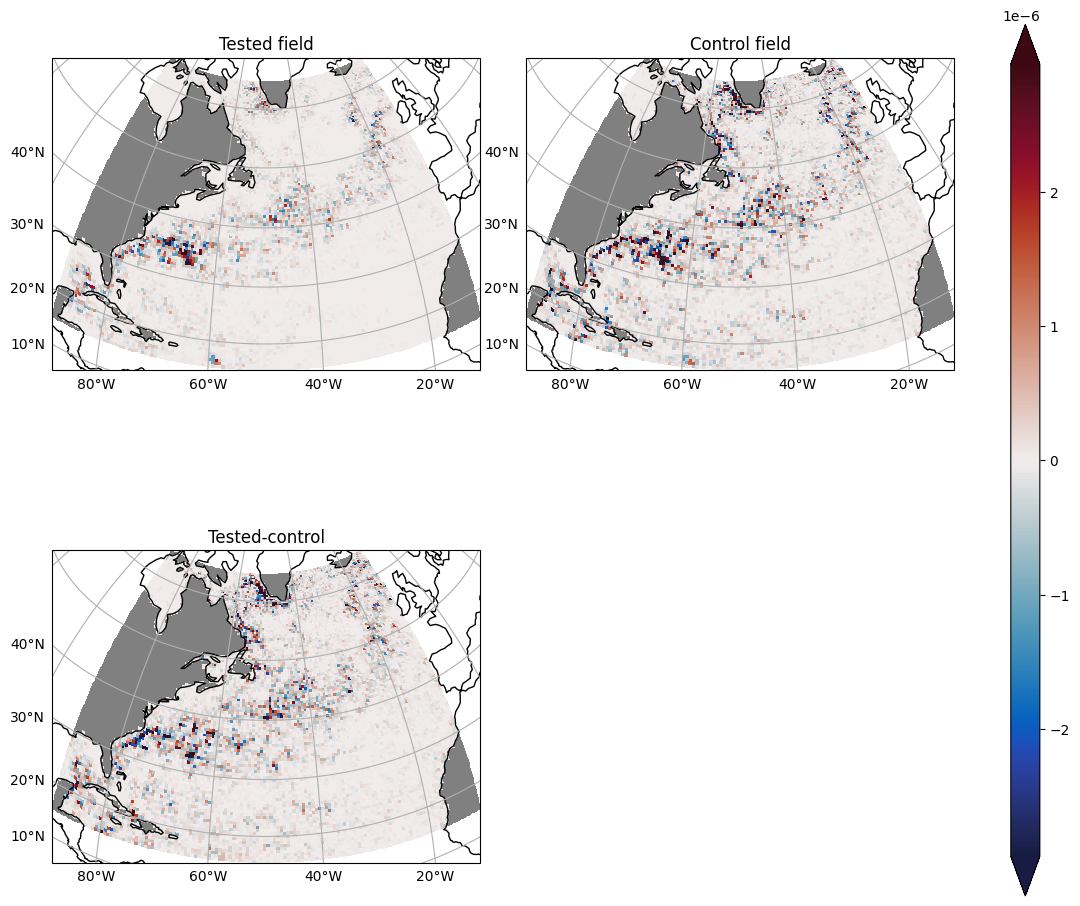

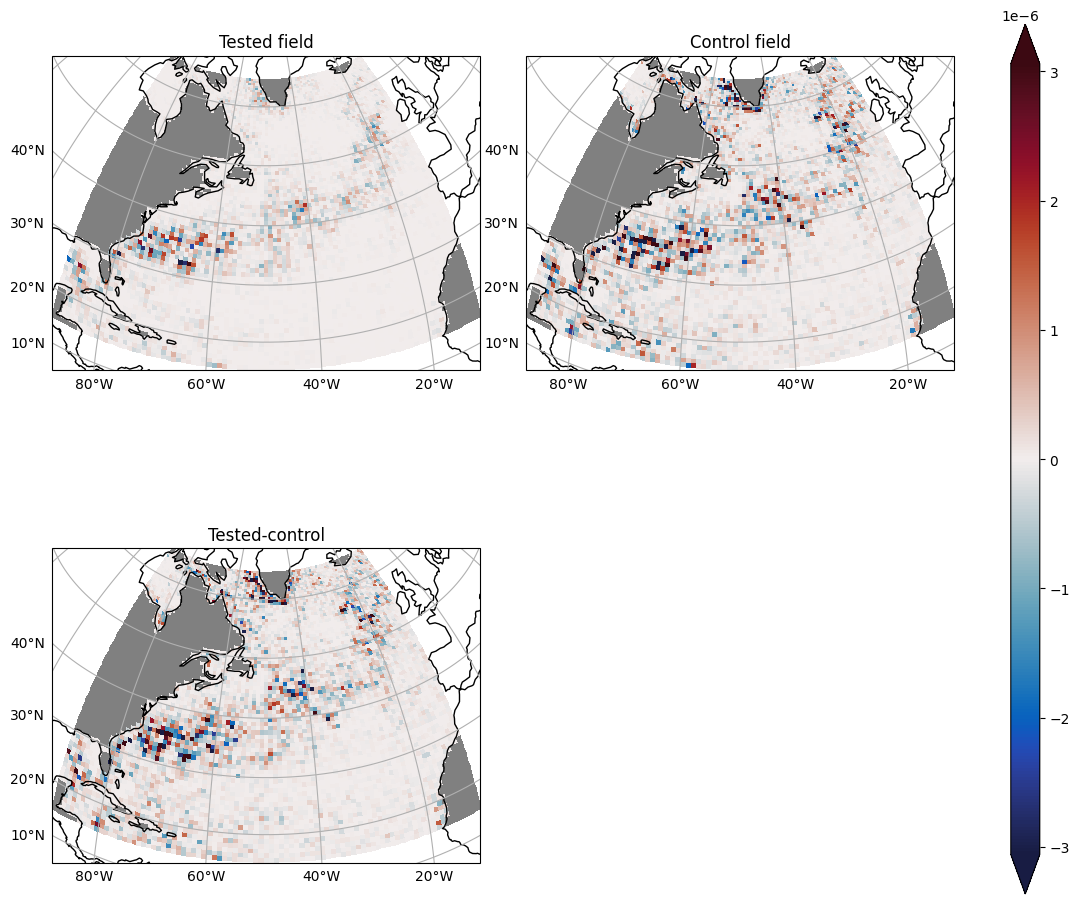

In [129]:
for factor in [4,6,9]:
    batch = dataset[f'test-{factor}'].split()
    data = batch.data
    param = batch.param
    state = batch.state
    compare(state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20u'], data.SGSx, param.wet_u, selector=select_NA)